In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,  precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

file_path = 'SQL_Dataset.csv'
df = pd.read_csv(file_path)

print(df.head())

                                               Query  Label
0                  " or pg_sleep  (  __TIME__  )  --      1
1  create user name identified by pass123 tempora...      1
2   AND 1  =  utl_inaddr.get_host_address   (    ...      1
3   select * from users where id  =  '1' or @ @1 ...      1
4   select * from users where id  =  1 or 1#"  ( ...      1


In [3]:
df

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1
...,...,...
30914,DELETE FROM door WHERE grow = 'small',0
30915,DELETE FROM tomorrow,0
30916,SELECT wide ( s ) FROM west,0
30917,SELECT * FROM ( SELECT slide FROM breath ),0


In [5]:
label_column = 'Label'
df['attack_flag'] = df[label_column]
df = df.drop(columns=['Label'])
print(df.head())

                                               Query  attack_flag
0                  " or pg_sleep  (  __TIME__  )  --            1
1  create user name identified by pass123 tempora...            1
2   AND 1  =  utl_inaddr.get_host_address   (    ...            1
3   select * from users where id  =  '1' or @ @1 ...            1
4   select * from users where id  =  1 or 1#"  ( ...            1


In [7]:
duplicates = df.duplicated().sum()
print(f"Брой на дублирани редове: {duplicates}")
df_cleaned = df.drop_duplicates()
print("Брой на дублирани редове след изчистване: ", df_cleaned.duplicated().sum())

Брой на дублирани редове: 12
Брой на дублирани редове след изчистване:  0


In [9]:
df_cleaned.to_csv('cleaned_SQL_Dataset.csv', index=False)

In [11]:
# Брой на злонамерените и незлонамерените заявки
attack_counts = df_cleaned['attack_flag'].value_counts()
print("Distribution of requests:\n", attack_counts)

print("Description of dataset:\n", df.describe())

Distribution of requests:
 attack_flag
0    19529
1    11378
Name: count, dtype: int64
Description of dataset:
         attack_flag
count  30919.000000
mean       0.368123
std        0.482303
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


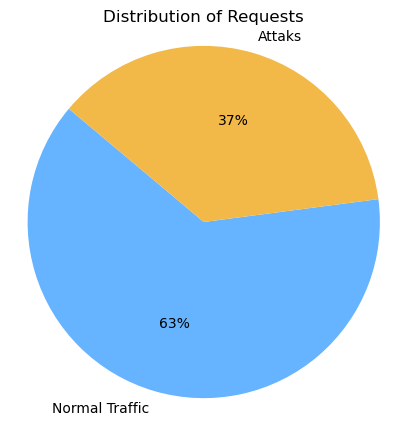

In [13]:
labels = ['Normal Traffic', 'Attaks']
sizes = [attack_counts[0], attack_counts[1]]
colors = ['#66b3ff','#f2b949']
explode = (0, 0)
plt.figure(figsize=(5, 5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.0f%%', startangle=140) 
plt.title('Distribution of Requests')
plt.axis('equal')
plt.show()

In [15]:
print(df_cleaned.dtypes)
print(df_cleaned.isnull().sum())

Query          object
attack_flag     int64
dtype: object
Query          0
attack_flag    0
dtype: int64


In [17]:
# Преобразуване на колоната Query
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_cleaned['Query'])

# Преобразуване на векторизираните данни в DataFrame
df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Добавяне на колоната attack_flag към новия DataFrame
df_tfidf['Query'] = df_cleaned['Query'].reset_index(drop=True)

print(df_tfidf.head())

    00  000001  000003  000004  000023  000045  00033926r  00041731d  \
0  0.0     0.0     0.0     0.0     0.0     0.0        0.0        0.0   
1  0.0     0.0     0.0     0.0     0.0     0.0        0.0        0.0   
2  0.0     0.0     0.0     0.0     0.0     0.0        0.0        0.0   
3  0.0     0.0     0.0     0.0     0.0     0.0        0.0        0.0   
4  0.0     0.0     0.0     0.0     0.0     0.0        0.0        0.0   

   00207473j  00217e  ...  zzca  zzcd  zzeh  zzip  zzkc  zzkx  zzmn   ã½  트리거  \
0        0.0     0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
1        0.0     0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
2        0.0     0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
3        0.0     0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
4        0.0     0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   

                                               Query  
0                  " or p

In [21]:
vectorizer = TfidfVectorizer(max_features=500)

# Векторизация на данните
X = vectorizer.fit_transform(df_cleaned['Query'])

# Преобразуване на векторизираните данни в DataFrame
df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Добавяне на колоната attack_flag към новия DataFrame
df_tfidf['attack_flag'] = df_cleaned['attack_flag'].reset_index(drop=True)

# Печат на първите редове
print(df_tfidf.head())

# Изчисляване на корелационната матрица
correlation_matrix = df_tfidf.corr()

# Печат на корелационната матрица
print(correlation_matrix)


    01   06   07   09  0x28  0x2e  0x4b774c75  0x4c4d6142  0x52515a50  \
0  0.0  0.0  0.0  0.0   0.0   0.0         0.0         0.0         0.0   
1  0.0  0.0  0.0  0.0   0.0   0.0         0.0         0.0         0.0   
2  0.0  0.0  0.0  0.0   0.0   0.0         0.0         0.0         0.0   
3  0.0  0.0  0.0  0.0   0.0   0.0         0.0         0.0         0.0   
4  0.0  0.0  0.0  0.0   0.0   0.0         0.0         0.0         0.0   

   0x544d5a4c  ...  won  worse  wp_options  wp_postmeta  wp_posts  xmltype  \
0         0.0  ...  0.0    0.0         0.0          0.0       0.0      0.0   
1         0.0  ...  0.0    0.0         0.0          0.0       0.0      0.0   
2         0.0  ...  0.0    0.0         0.0          0.0       0.0      0.0   
3         0.0  ...  0.0    0.0         0.0          0.0       0.0      0.0   
4         0.0  ...  0.0    0.0         0.0          0.0       0.0      0.0   

   ydpu  yesterday  yourself  attack_flag  
0   0.0        0.0       0.0            1  
1   

In [23]:
# Избиране на важни колони (примерно първите 20 колони)
important_columns = df_tfidf.columns[:20]

# Изчисляване на корелационната матрица само за важните колони
correlation_matrix = df_tfidf[important_columns].corr()

In [25]:
#Използване на паралелна обработка
def compute_correlation(i, j):
    return np.corrcoef(df_tfidf.iloc[:, i], df_tfidf.iloc[:, j])[0, 1]

n = len(df_tfidf.columns)
correlation_matrix = np.zeros((n, n))

results = Parallel(n_jobs=-1)(delayed(compute_correlation)(i, j) for i in range(n) for j in range(i, n))
for k, (i, j) in enumerate(((i, j) for i in range(n) for j in range(i, n))):
    correlation_matrix[i, j] = correlation_matrix[j, i] = results[k]

# Преобразуване в DataFrame за визуализация
correlation_matrix = pd.DataFrame(correlation_matrix, index=df_tfidf.columns, columns=df_tfidf.columns)


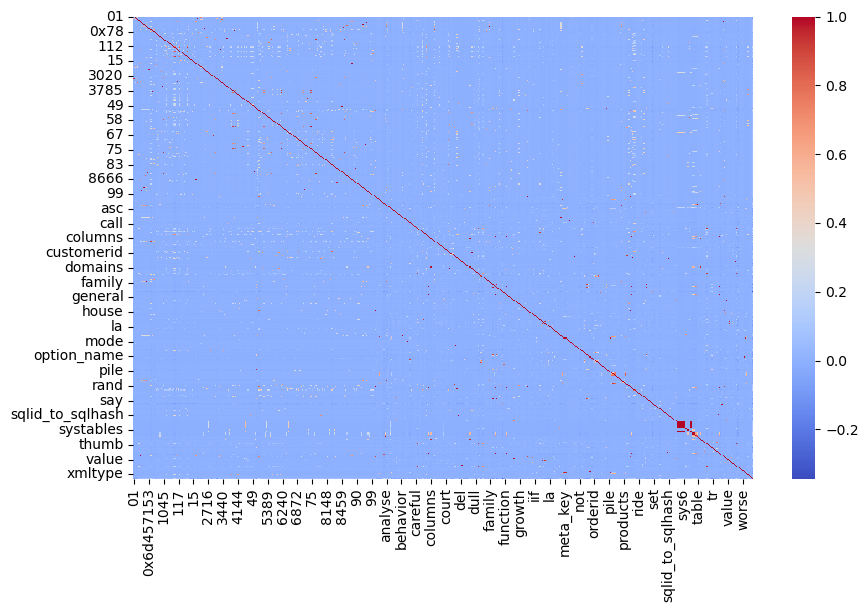

In [39]:
# Създаване на heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.show()

In [41]:
# Идентифициране на силно корелиращите категории
threshold = 0.8
highly_correlated = np.where(np.abs(correlation_matrix) > threshold)
highly_correlated_pairs = [(correlation_matrix.columns[x], correlation_matrix.columns[y]) for x, y in zip(*highly_correlated) if x != y and x < y]

print("Силно корелиращи категории:")
for pair in highly_correlated_pairs:
    print(pair)


Силно корелиращи категории:
('01', '31')
('07', '1996')
('09', '34')
('0x2e', 'updatexml')
('0x4b774c75', '9627')
('0x52515a50', '9255')
('0x544d5a4c', '8514')
('0x5c', 'extractvalue')
('0x694a4745', '8466')
('0x6d457153', '2388')
('0x7171706a71', '0x717a767a71')
('0x7171706a71', 'concat')
('0x717a767a71', 'concat')
('0x76555642', '3824')
('1032', '3623')
('1045', '5584')
('1045', '7562')
('1045', '8488')
('113', '118')
('113', '122')
('1161', '3393')
('118', '122')
('1808', '8666')
('3020', '6703')
('3785', '3931')
('3785', '6237')
('3785', '7469')
('3931', '6237')
('3931', '7469')
('4249', '7259')
('4906', '8459')
('50', 'percent')
('500000000', 'abcdefg')
('500000000', 'hex')
('500000000', 'randomblob')
('5192', '6237')
('5192', '7469')
('5451', 'system_users')
('5584', '7562')
('5584', '8488')
('6237', '7469')
('7185', '9354')
('7562', '8488')
('83', 'crypt_key')
('8403', '8899')
('abcdefg', 'hex')
('abcdefg', 'randomblob')
('abcdefg', 'upper')
('acf', 'menu_order')
('all', 'union'

In [43]:
# премахване на силно корелиращите категории
columns_to_drop = [pair[1] for pair in highly_correlated_pairs]
# Премахване на силно корелиращите категории от DataFrame
df_tfidf_reduced = df_tfidf.drop(columns=columns_to_drop)
# Преглед на новия DataFrame без силно корелиращите категории
print(df_tfidf_reduced.head())


    01   06   07   09  0x28  0x2e  0x4b774c75  0x4c4d6142  0x52515a50  \
0  0.0  0.0  0.0  0.0   0.0   0.0         0.0         0.0         0.0   
1  0.0  0.0  0.0  0.0   0.0   0.0         0.0         0.0         0.0   
2  0.0  0.0  0.0  0.0   0.0   0.0         0.0         0.0         0.0   
3  0.0  0.0  0.0  0.0   0.0   0.0         0.0         0.0         0.0   
4  0.0  0.0  0.0  0.0   0.0   0.0         0.0         0.0         0.0   

   0x544d5a4c  ...  which  widely  won  worse  wp_posts  xmltype  ydpu  \
0         0.0  ...    0.0     0.0  0.0    0.0       0.0      0.0   0.0   
1         0.0  ...    0.0     0.0  0.0    0.0       0.0      0.0   0.0   
2         0.0  ...    0.0     0.0  0.0    0.0       0.0      0.0   0.0   
3         0.0  ...    0.0     0.0  0.0    0.0       0.0      0.0   0.0   
4         0.0  ...    0.0     0.0  0.0    0.0       0.0      0.0   0.0   

   yesterday  yourself  attack_flag  
0        0.0       0.0            1  
1        0.0       0.0            1  
2 

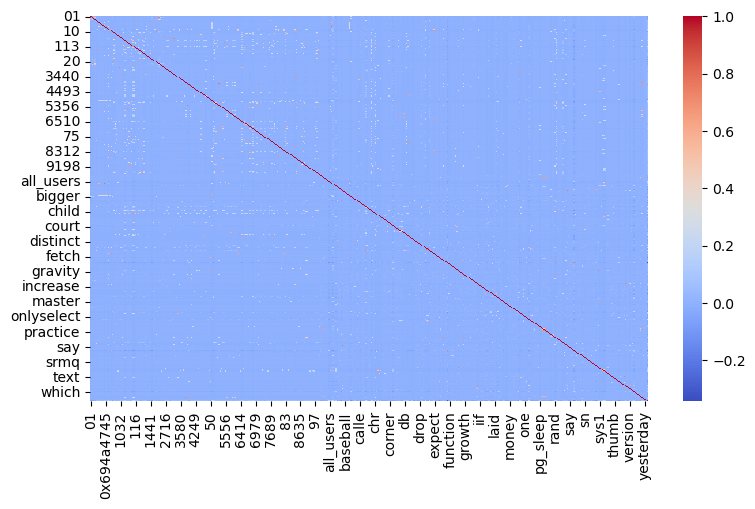

In [51]:
# Изчисляване на новата корелационна матрица
correlation_matrix_reduced = df_tfidf_reduced.corr()

# Създаване на heatmap на новата корелационна матрица
plt.figure(figsize=(9, 5))
sns.heatmap(correlation_matrix_reduced, annot=False, cmap='coolwarm', fmt=".2f")
plt.show()

In [53]:
# Naive Bayes
vectorizer = TfidfVectorizer() 
X = vectorizer.fit_transform(df['Query'])
# Преобразуване на векторизираните данни в DataFrame
df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
# Добавяне на колоната attack_flag към новия DataFrame 
df_tfidf['attack_flag'] = df['attack_flag'].reset_index(drop=True)

In [55]:
# Определяне на входни и изходни променливи
X = df_tfidf.drop(['attack_flag'], axis=1)
y = df_tfidf['attack_flag']

# Разделяне на данните на обучаващ и тестов набор
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [57]:
# Създаване на Naïve Bayes модел
# Ще използваме Multinomial Naïve Bayes модел за класификация.
nb_model = MultinomialNB()

# Обучение на модела
nb_model.fit(X_train, y_train)

MultinomialNB()

In [59]:
# Предсказания върху тестовия набор
y_pred = nb_model.predict(X_test)

print("Класификационен отчет:\n", classification_report(y_test, y_pred))

Класификационен отчет:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      5830
           1       0.97      0.90      0.93      3446

    accuracy                           0.95      9276
   macro avg       0.96      0.94      0.95      9276
weighted avg       0.95      0.95      0.95      9276



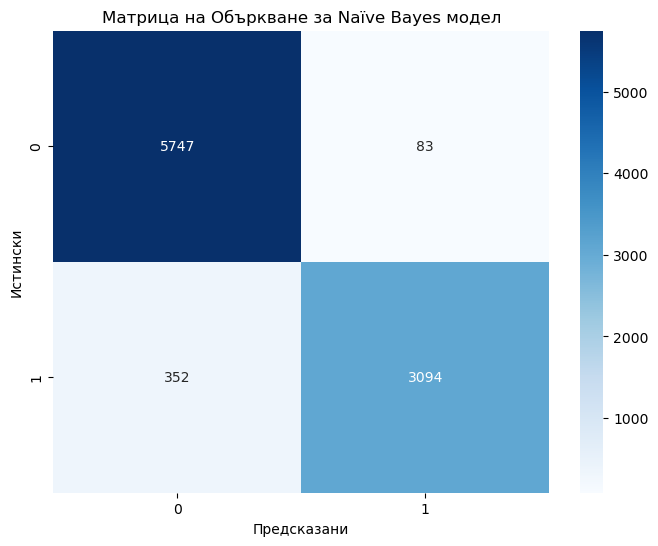

In [61]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Предсказани')
plt.ylabel('Истински')
plt.title('Матрица на Объркване за Naïve Bayes модел')
plt.show()

In [63]:
# Предсказания върху тестовия набор
y_pred = nb_model.predict(X_test)

# Изчисляване на метриките
report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"Accuracy: {accuracy:.2f}")


Precision: 0.95
Recall: 0.95
F1 Score: 0.95
Accuracy: 0.95


In [65]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

y_pred = nb_model.predict(X_test)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

report = classification_report(y_test, y_pred)
print(report)

Precision: 0.95
Recall: 0.95
F1 Score: 0.95
Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5830
           1       0.97      0.90      0.93      3446

    accuracy                           0.95      9276
   macro avg       0.96      0.94      0.95      9276
weighted avg       0.95      0.95      0.95      9276



In [67]:
#KNN
knn_model = KNeighborsClassifier(n_neighbors=5) 

knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [69]:
y_pred = knn_model.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Precision: 0.78
Recall: 0.48
F1 Score: 0.40
Accuracy: 0.48


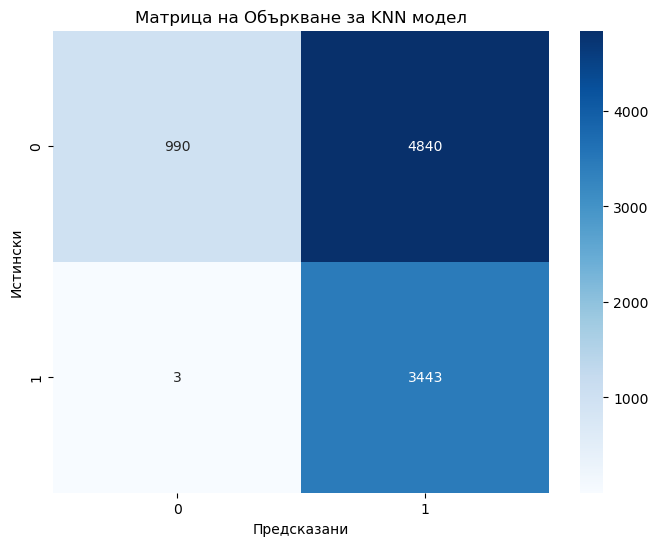

In [70]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Предсказани')
plt.ylabel('Истински')
plt.title('Матрица на Объркване за KNN модел')
plt.show()

In [73]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [74]:
y_pred = rf_model.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Precision: 0.87
Recall: 0.80
F1 Score: 0.95
Accuracy: 0.80


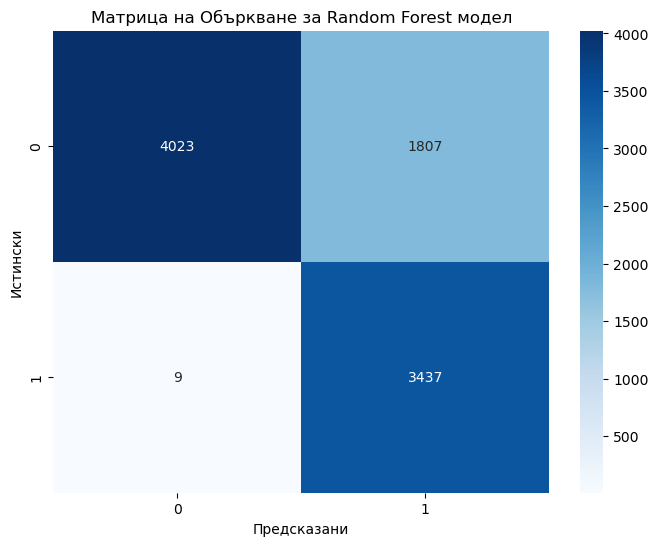

In [75]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Предсказани')
plt.ylabel('Истински')
plt.title('Матрица на Объркване за Random Forest модел')
plt.show()

In [79]:
# Log reggresion
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Предсказания и оценка
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5830
           1       0.98      0.89      0.93      3446

    accuracy                           0.95      9276
   macro avg       0.96      0.94      0.95      9276
weighted avg       0.96      0.95      0.95      9276

[[5782   48]
 [ 381 3065]]
Accuracy: 0.95


Precision: 0.96
Recall: 0.95
F1 Score: 0.95
Accuracy: 0.95


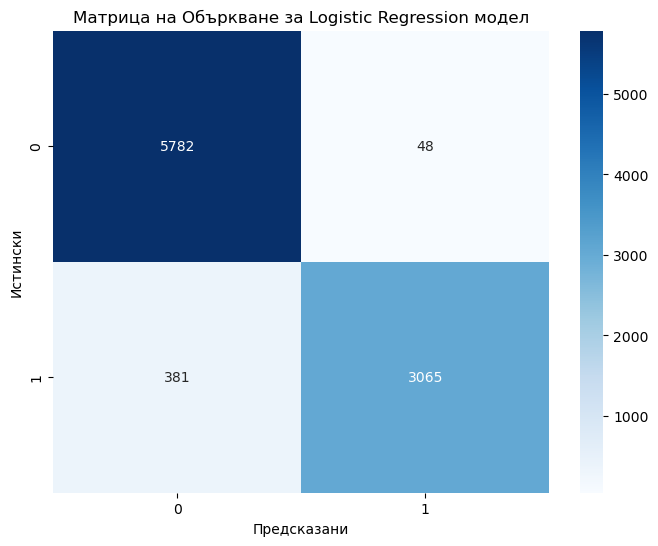

In [80]:
report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

# Преглед на метриките
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"Accuracy: {accuracy:.2f}")

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Предсказани')
plt.ylabel('Истински')
plt.title('Матрица на Объркване за Logistic Regression модел')
plt.show()

In [85]:
# Neural networks
from tensorflow.keras.layers import Dense, Dropout, Input

model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │       3,165,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,174,273 (12.11 MB)

 Trainable params: 3,174,273 (12.11 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
# Обучение на модела
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/5
542/542 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.8339 - loss: 0.3521 - val_accuracy: 0.9845 - val_loss: 0.0509
Epoch 2/5
542/542 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9933 - loss: 0.0277 - val_accuracy: 0.9836 - val_loss: 0.0514
Epoch 3/5
542/542 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9957 - loss: 0.0163 - val_accuracy: 0.9861 - val_loss: 0.1037
Epoch 4/5
542/542 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9982 - loss: 0.0052 - val_accuracy: 0.8383 - val_loss: 0.2249
Epoch 5/5
542/542 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9984 - loss: 0.0046 - val_accuracy: 0.8314 - val_loss: 0.3084


In [89]:
# Предсказания върху тестовия набор
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Изчисляване на метриките
report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

# Преглед на метриките
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"Accuracy: {accuracy:.2f}")

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Precision: 0.88
Recall: 0.82
F1 Score: 0.82
Accuracy: 0.82


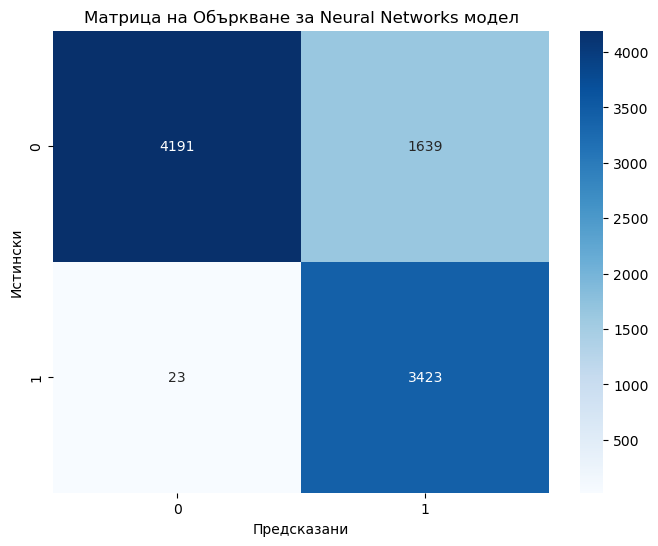

In [91]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Предсказани')
plt.ylabel('Истински')
plt.title('Матрица на Объркване за Neural Networks модел')
plt.show()

In [93]:
data = {
    'Model': ['Naïve Bayes', 'KNN', 'Neural Networks', 'Random Forest'],
    'Precision': [0.95, 0.78, 0.88, 0.87],
    'Recall': [0.95, 0.48, 0.82, 0.80],
    'F1 Score': [0.95, 0.40, 0.82, 0.81],
    'Accuracy': [0.95, 0.48, 0.82, 0.80]
}

df_results = pd.DataFrame(data)
print(df_results)

             Model  Precision  Recall  F1 Score  Accuracy
0      Naïve Bayes       0.95    0.95      0.95      0.95
1              KNN       0.78    0.48      0.40      0.48
2  Neural Networks       0.88    0.82      0.82      0.82
3    Random Forest       0.87    0.80      0.81      0.80


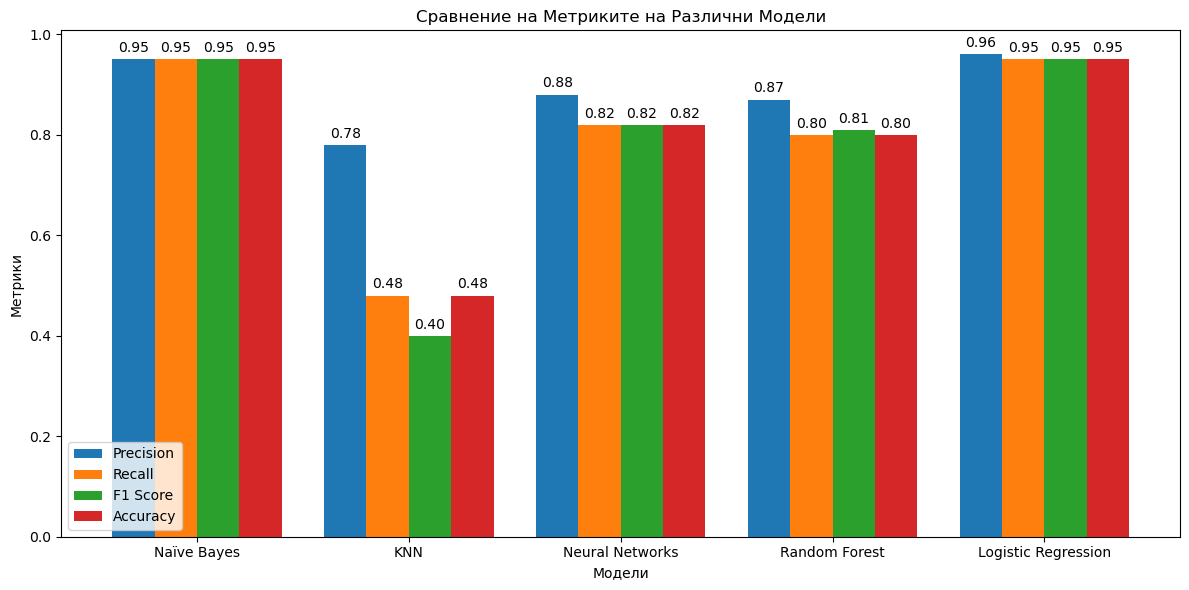

In [87]:
models = ['Naïve Bayes', 'KNN', 'Neural Networks', 'Random Forest', 'Logistic Regression']
precision = [0.95, 0.78, 0.88, 0.87, 0.96]
recall = [0.95, 0.48, 0.82, 0.80, 0.95]
f1_score = [0.95, 0.40, 0.82, 0.81, 0.95]
accuracy = [0.95, 0.48, 0.82, 0.80, 0.95]

x = np.arange(len(models))  
width = 0.2  

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width*1.5, precision, width, label='Precision')
rects2 = ax.bar(x - width/2, recall, width, label='Recall')
rects3 = ax.bar(x + width/2, f1_score, width, label='F1 Score')
rects4 = ax.bar(x + width*1.5, accuracy, width, label='Accuracy')

ax.set_xlabel('Модели')
ax.set_ylabel('Метрики')
ax.set_title('Сравнение на Метриките на Различни Модели')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()